# EfficientDet Tutorial: inference, eval, and training 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

# 0. Install and view graph.

## 0.1 Install package and download source code/image.



In [0]:
%%capture
#@title
# Install tensorflow and pycocotools
!pip install tensorflow
!pip install pytype
# The default pycocotools doesn't work for python3: https://github.com/cocodataset/cocoapi/issues/49
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
else:
  !git pull

In [0]:
MODEL = 'efficientdet-d0'  #@param

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

# Prepare image and visualization settings.
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png
import os
img_path = os.path.join(os.getcwd(), 'img.png')

min_score_thresh = 0.4  #@param
max_boxes_to_draw = 200  #@param
line_thickness =   2#@param

import PIL
# Get the largest of height/width and round to 128.
image_size = max(PIL.Image.open(img_path).size)

Use model in /content/automl/efficientdet/efficientdet-d0
--2020-04-23 04:47:47--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘img.png’

img.png             100%[===================>]   3.89M  --.-KB/s    in 0.1s    

2020-04-23 04:47:47 (28.1 MB/s) - ‘img.png’ saved [4080549/4080549]



## 0.2 View graph in TensorBoard

In [0]:
!python model_inspect.py --model_name={MODEL} --logdir=logs &> /dev/null
%load_ext tensorboard
%tensorboard --logdir logs

# 1. inference

## 1.1 Benchmark networrk latency
There are two types of latency:
network latency and end-to-end latency.

*   network latency: from the first conv op to the network class and box prediction.
*   end-to-end latency: from image preprocessing, network, to the final postprocessing to generate a annotated new image.


In [0]:
# benchmaak network latency
!python model_inspect.py --runmode=bm --model_name=efficientdet-d3

# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0:  14.9ms,  FPS = 67.2   (batch size 8 FPS=92.8)
# D1:  29.0ms,  FPS = 34.4   (batch size 8 FPS=41.6)
# D2:  43.2ms,  FPS = 23.1   (batch size 8 FPS=27.2)
# D3:  76.7ms,  FPS = 13.0   (batch size 8 FPS=14.4)

2020-04-23 04:57:20.357746: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-04-23 04:57:22.571519: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-04-23 04:57:22.576765: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2000175000 Hz
2020-04-23 04:57:22.576954: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x176f100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-23 04:57:22.576983: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-04-23 04:57:22.578914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-23 04:57:22.71

## 1.2 Benchmark end-to-end latency

In [0]:
# Benchmark end-to-end latency (: preprocess + network + posprocess).
#
# With colab + Tesla T4 GPU, here are the batch size 1 latency summary:
# D0 (AP=33.5): 23.8ms,  FPS = 42.1   (batch size 4, FPS=79.3)
# D1 (AP=39.6): 36.1ms,  FPS = 27.7   (batch size 4, FPS=39.1)
# D2 (AP=43.0): 50.7ms,  FPS = 19.7   (batch size 4, FPS=26.0)
# D3 (AP=45.8): 84.6ms,  FPS = 11.8   (batch size 4, FPS=13.3)
# D4 (AP=49.4): 140ms,   FPS =  7.1   (batch size 4, FPS=7.5)
# D5 (AP=50.7): 298ms,   FPS =  3.6
# D6 (AP=51.7): 386ms,   FPS =  2.6

m = 'efficientdet-d0'  # @param
batch_size =   1# @param
m_path = download(m)

saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}
!python model_inspect.py --runmode=saved_model_benchmark --model_name={m} \
  --ckpt_path={m_path} --saved_model_dir={saved_model_dir} \
  --batch_size={batch_size}  --input_image=testdata/img1.jpg


2020-04-23 05:31:39.074754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-04-23 05:31:41.445144: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-04-23 05:31:41.450545: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2000175000 Hz
2020-04-23 05:31:41.450729: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3047100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-23 05:31:41.450758: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-04-23 05:31:41.452797: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-23 05:31:41.59

## 1.3 Inference images.

---



In [0]:
# first export a saved model.
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}
!python model_inspect.py --runmode=saved_model --model_name={MODEL} \
  --ckpt_path={ckpt_path} --saved_model_dir={saved_model_dir}

# Then run saved_model_infer to do inference.
# Notably: batch_size, image_size must be the same as when it is exported.
serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}

!python model_inspect.py --runmode=saved_model_infer \
  --saved_model_dir={saved_model_dir} \
  --model_name={MODEL}  --input_image=testdata/img1.jpg  \
  --output_image_dir={serve_image_out}

2020-04-23 06:11:04.560938: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-04-23 06:11:06.929524: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-04-23 06:11:06.935169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2000175000 Hz
2020-04-23 06:11:06.935360: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x23cd100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-23 06:11:06.935391: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-04-23 06:11:06.937439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-23 06:11:07.08

In [0]:
from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

mkdir: cannot create directory ‘serve_image_out’: File exists
2020-04-23 01:10:37.470291: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-04-23 01:10:39.990636: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-04-23 01:10:39.990893: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2607100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-23 01:10:39.990931: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-04-23 01:10:39.993014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-23 01:10:40.142491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had nega

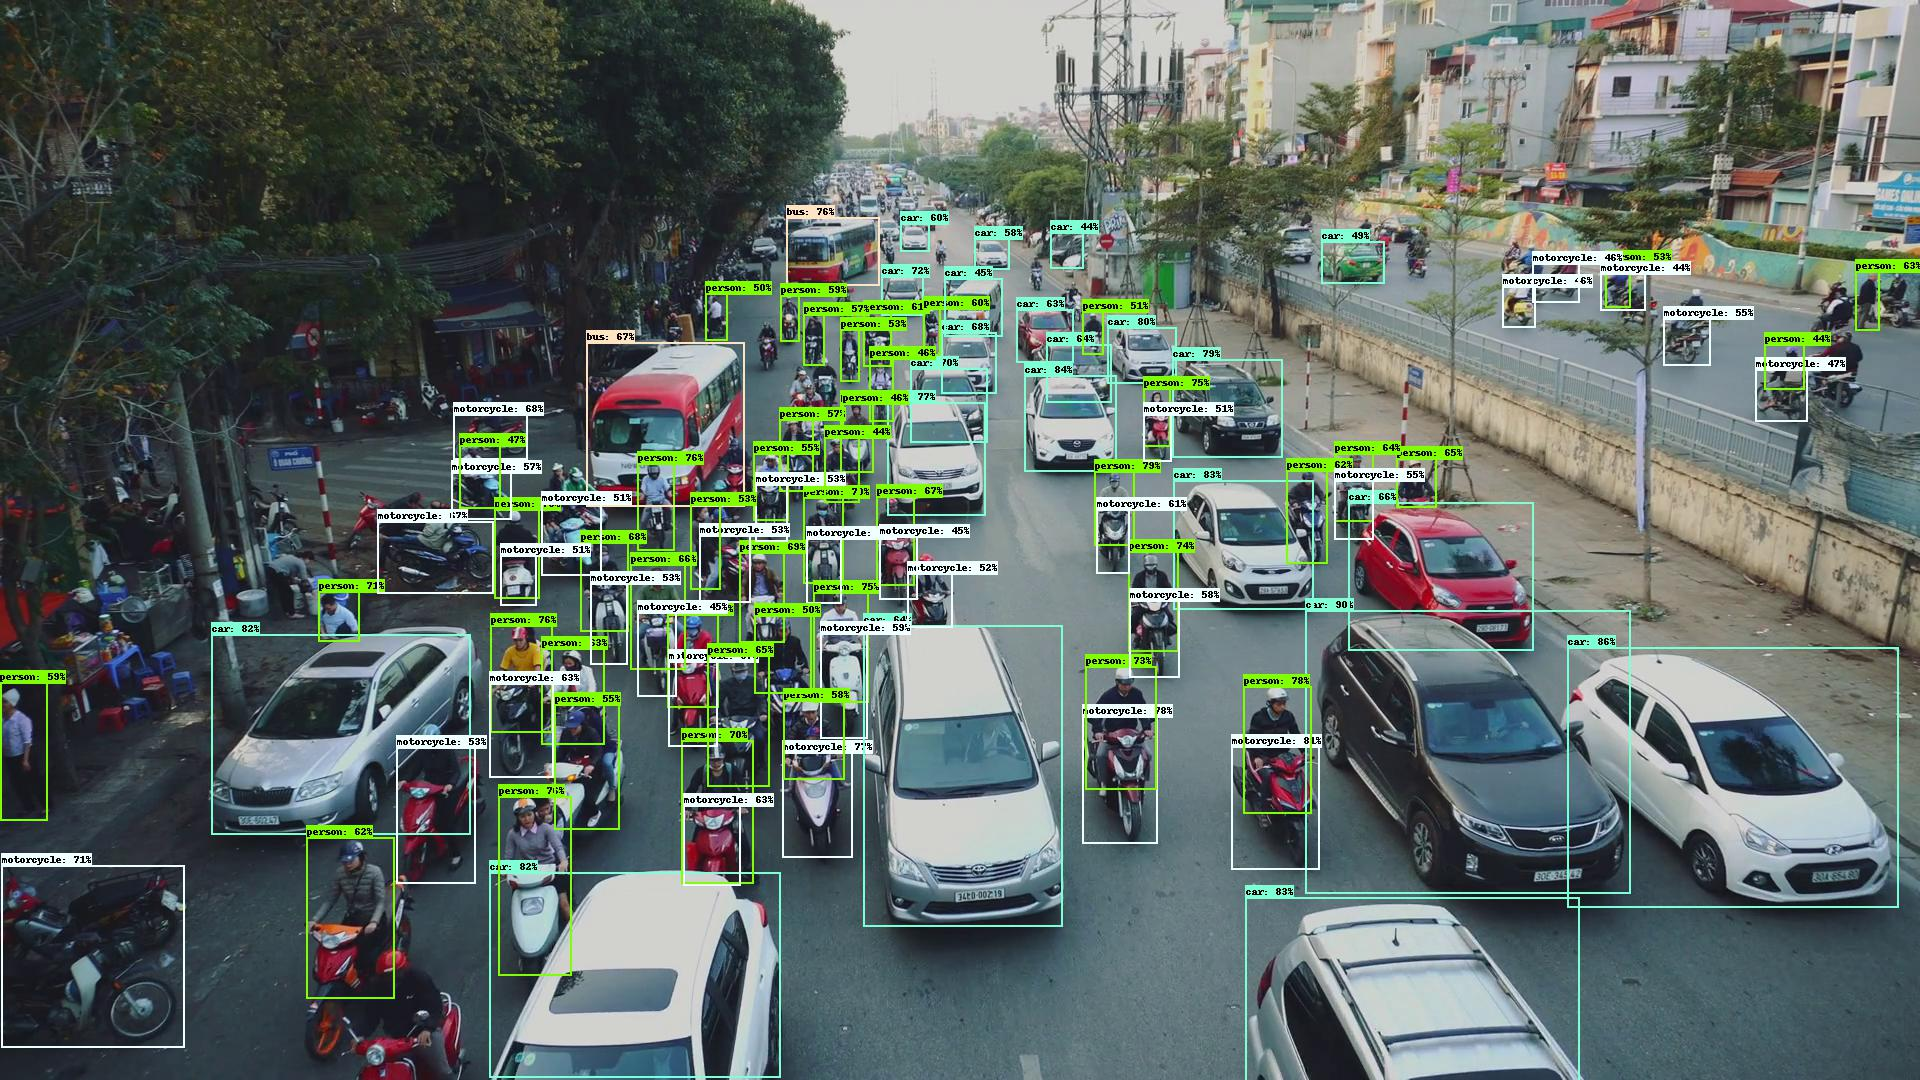

In [0]:
# In case you need to specify different image size or batch size or #boxes, then
# you need to export a new saved model and run the inferernce.

serve_image_out = 'serve_image_out'
!mkdir {serve_image_out}
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

# Step 1: export model
!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --hparams="image_size=1920x1280" --saved_model_dir={saved_model_dir}

# Step 2: do inference with saved model.
!python model_inspect.py --runmode=saved_model_infer \
  --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
  --hparams="image_size=1920x1280"  --saved_model_dir={saved_model_dir} \
  --input_image=img.png --output_image_dir={serve_image_out}

from IPython import display
display.display(display.Image(os.path.join(serve_image_out, '0.jpg')))

## 1.4 Inference video

In [0]:
# step 0: download video
video_url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov'  # @param
!wget {video_url} -O input.mov

# Step 1: export model
saved_model_dir = 'savedmodel'
!rm -rf {saved_model_dir}

!python model_inspect.py --runmode=saved_model \
  --model_name=efficientdet-d0 --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir}

# Step 2: do inference with saved model using saved_model_video
!python model_inspect.py --runmode=saved_model_video \
  --model_name=efficientdet-d0   --ckpt_path=efficientdet-d0 \
  --saved_model_dir={saved_model_dir} \
  --input_video=input.mov --output_video=output.mov
# Then you can view the output.mov

--2020-04-23 03:48:16--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/data/video480p.mov
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 2a00:1450:4013:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18511760 (18M) [application/octet-stream]
Saving to: ‘input.mov’

input.mov           100%[===================>]  17.65M  --.-KB/s    in 0.1s    

2020-04-23 03:48:16 (146 MB/s) - ‘input.mov’ saved [18511760/18511760]

2020-04-23 03:48:18.987106: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-04-23 03:48:21.066018: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-04-23 03:48

# 3. COCO evaluation

## 3.1 COCO evaluation on validation set.

In [0]:
if 'val2017' not in os.listdir():
  !wget http://images.cocodataset.org/zips/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip -q val2017.zip
  !unzip annotations_trainval2017.zip

  !mkdir tfrecrod
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

--2020-04-23 03:57:25--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.107.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.107.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.4MB/s    in 8.1s    

2020-04-23 03:57:33 (95.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-04-23 03:57:34--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.244.76
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.244.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  95.2MB/s    in 2.5s    

2020

In [0]:
# Evalute on validation set (takes about 10 mins for efficientdet-d0)
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json  \
    --use_tpu=False

2020-04-23 04:00:36.653339: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term

W0423 04:00:38.994576 140227058120576 module_wrapper.py:138] From main.py:222: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0423 04:00:38.994807 140227058120576 module_wrapper.py:138] From main.py:227: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0423 04:00:38.995015 140227058120576 module_wrapper.py:138] From main.py:230: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.

I0423 04:00:38.995242 140227058120576 main.py:242] {'name': 'efficientdet-d0', 'act_type': 'swish', 'image_size': 512, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_

## 3.2 COCO evaluation on test-dev.

In [0]:
# Eval on test-dev is slow (~40 mins), please be cautious. 
RUN_EXPENSIVE_TEST_DEV_EVAL = True  #@param

if RUN_EXPENSIVE_TEST_DEV_EVAL == True:
  !rm *.zip *.tar tfrecord/ val2017/   # Cleanup disk space
  # Download and convert test-dev data.
  if "test2017" not in os.listdir():
    !wget http://images.cocodataset.org/zips/test2017.zip
    !unzip -q test2017.zip
    !wget http://images.cocodataset.org/annotations/image_info_test2017.zip
    !unzip image_info_test2017.zip

    !mkdir tfrecrod
    !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
          --image_dir=test2017 \
          --image_info_file=annotations/image_info_test-dev2017.json \
          --output_file_prefix=tfrecord/testdev \
          --num_shards=32

  # Evalute on validation set: non-empty testdev_dir is the key pararmeter.
  # Also, test-dev has 20288 images rather than val 5000 images.
  !mkdir testdev_output
  !python main.py --mode=eval  \
      --model_name={MODEL}  --model_dir={ckpt_path}  \
      --validation_file_pattern=tfrecord/testdev*  \
      --use_tpu=False --eval_batch_size=8 \
      --testdev_dir='testdev_output' --eval_samples=20288
  !rm -rf test2017  # delete images to release disk space.
  # Now you can submit testdev_output/detections_test-dev2017_test_results.json to
  # coco server: https://competitions.codalab.org/competitions/20794#participate

# 4. Training EfficientDets on PASCAL.

## 4.1 Prepare data

In [0]:
# Get pascal voc 2012 trainval data
import os
if 'VOCdevkit' not in os.listdir():
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
  !tar xf VOCtrainval_11-May-2012.tar

  !mkdir tfrecord
  !PYTHONPATH=".:$PYTHONPATH"  python dataset/create_pascal_tfrecord.py  \
    --data_dir=VOCdevkit --year=VOC2012  --output_path=tfrecord/pascal

# Pascal has 5717 train images with 100 shards epoch, here we use a single shard
# for demo, but users should use all shards pascal-*-of-00100.tfrecord.
file_pattern = 'pascal-00000-of-00100.tfrecord'  # @param
images_per_epoch = 57 * len(tf.io.gfile.glob('tfrecord/' + file_pattern))
images_per_epoch = images_per_epoch // 8 * 8  # round to 64.
print('images_per_epoch = {}'.format(images_per_epoch))

## 4.2 Train Pascal VOC 2012 from ImageNet checkpoint for Backbone.

In [0]:
# Train efficientdet from scratch with backbone checkpoint.
backbone_name = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}[MODEL]


# generating train tfrecord is large, so we skip the execution here.
import os
if backbone_name not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckptsaug/{backbone_name}.tar.gz
  !tar xf {backbone_name}.tar.gz

!mkdir /tmp/model_dir
# key option: use --backbone_ckpt rather than --ckpt.
# Don't use ema since we only train a few steps.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern} \
    --val_json_file=tfrecord/json_pascal.json \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-scratch  \
    --backbone_ckpt={backbone_name} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0" \
    --use_tpu=False 

## 4.3 Train Pascal VOC 2012 from COCO checkpoint for the whole net.

In [0]:
# generating train tfrecord is large, so we skip the execution here.
import os
if MODEL not in os.listdir():
  !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
  !tar xf {MODEL}.tar.gz

!mkdir /tmp/model_dir/
# key option: use --ckpt rather than --backbone_ckpt.
!python main.py --mode=train_and_eval \
    --training_file_pattern=tfrecord/{file_pattern} \
    --validation_file_pattern=tfrecord/{file_pattern} \
    --val_json_file=tfrecord/json_pascal.json \
    --model_name={MODEL} \
    --model_dir=/tmp/model_dir/{MODEL}-finetune \
    --ckpt={MODEL} \
    --train_batch_size=8 \
    --eval_batch_size=8 --eval_samples={images_per_epoch}  \
    --num_examples_per_epoch={images_per_epoch}  --num_epochs=1  \
    --hparams="num_classes=20,moving_average_decay=0" \
    --use_tpu=False 

## 4.4 View tensorboard for loss and accuracy.


In [0]:
%load_ext tensorboard
%tensorboard --logdir /tmp/model_dir/
# Notably, this is just a demo with almost zero accuracy due to very limited
# training steps, but we can see finetuning has smaller loss than training
# from scratch at the begining.